# Tutorial 5: Less Time Wrangling Data, More Time Understanding/Actioning it

**API Version: JuliaLang NavAbilitySDK.py**

## YouTube Walk Through Video

A walk through of this video has been prepared and can be found at:

[![Tutorial 5 Walk Through](https://img.youtube.com/vi/4kKTIAOqEfU/0.jpg)](https://youtu.be/4kKTIAOqEfU)

## Introduction

NavAbility developed a case study for marine vehicle navigation which direclty addresses GPS-denied navigation from radar point cloud data.  The underlying SLAM solver is supported by NavAbility as open core software.  Links to the open source code and deeper discussions are available by following links from [Marine Case Study Blog post](https://www.navability.io/2022/02/04/application-example-marine-vehicle-mapping-systems-for-collision-avoidance-and-planning/).

This tutorial shows how interaction is done with ease and efficiency.  This tutorial builds on previous tutorials that show how and why factor graphs are so important, as well other tutorials showing some of the robust (non-Gaussian) solver features that are available when building multi-sensor navigation and mapping systems that must combine challenging, ambiguous, and contradictory measurements and data cues.

## Problem Statement

Marine operations in harbor and populated river environments will see increased autonomy with major benefits for safety and efficacy, but the navigational environment poses a number of vital challenges.  In developing and testing proof-of-concept systems, four very specific challenges arose:
- GPS data can occasionaly drop out, specifically when maneuvering under bridges or between tall structures;
- Various perception sensors each perform really well with reasonable availability for seeing obstacles or aiding navigation, but no one sensor alone provides a home run solution;
- Practical development testing an operations produces large amounts of recorded robot data, but the data quickly becomes overwhelming and difficult to action;
- How to share / integrate measurement data and navigation between agents (human or autonomous), as well as with shore side operations;

## The Value (Broader Application)

- By being able to rapidly develop advanced multi-sensor perception, localization, and mapping ideas drastically reduces the cost and risk of introducing highly focussed autonomy/safety features into existing operations.
- Access to both raw data and actionable SLAM results provides a major platform for machine learning tasks, such as training predictors that have either geometric of semantic relevance -- e.g. learning vehicle behaviors or better classifiers.
- Access to a temporal/spatial database allows various sessions to be brought together with NavAbility's map merging technology.

## A Marine SLAM Solution

The marine case study shows benefits value of persistent simultaneous localization and mapping SLAM solutions.
```
Raw Data -------------> SLAM Solving ----------------> Action / Visualize Results
              ^                              |
              |                              |
        Enhance the  <--------------- Deeper processing of data
        factor graph                    with previous results
```

## The Data is Alive and Available

Shows a piece of the boat trajectory.  The interactive code below will help visualize the trajectory of the target boat, which was estimated from our vehicle regardless of whether GPS was working or not!

The first piece of code shows:
- the factor graph exists
- the size of the factor graph
- which variables and factors are in the factor graph

In the sections hereafter, you will learn more about which data is being stored in each of these graph nodes, how the SLAM solution is processed and why that is crucial for multisensor navigation, and how to immediately interact the data on the platform for youself. 


# ICRA Survey
Thanks for doing our tutorials! We really want to make sure this is valuable for you. 

This [quick 2 minute survey](https://docs.google.com/forms/d/e/1FAIpQLScQiZHguPN7YP18-VhfbqqQw621EswuBIJZj191x70CPrCiKw/viewform?vc=0&c=0&w=1&flr=0) will help us improve them for next year's workshop.

## Loading Necessary Packages

Load the necessary packages or accesing the data:

In [1]:
# # ONLY IF REQUIRED, Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install navabilitysdk

In [1]:
from navability.entities import *
from navability.services import *
from uuid import uuid4
import asyncio
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image
import json

## Read-only Data, userId=`examples@navability.io`

### Robot:Session => MarineASV_ICRA2022:Tutorial5_1000

Point the SDK context to the right location, but selecting the User:Robot:Session

In [2]:
client = NavAbilityHttpsClient()

# you need a unique userId:robotId, and can keep using that across all tutorials
userId = "examples@navability.io"
robotId = "MarineASV_ICRA2022"
sessionId = "Tutorial5_1000"

context = Client(userId, robotId, sessionId)

### Variables in Session?

To get a sense of scale of the dataset, we can look at the number of variables under this session:

In [3]:
lbls = await listVariables(client, context)
print(lbls)

['x284', 'x274', 'x279', 'x259', 'x254', 'x249', 'x234', 'x244', 'x239', 'x0', 'x4', 'x9', 'x14', 'x19', 'x24', 'x29', 'x34', 'x69', 'x74', 'x44', 'x39', 'x49', 'x59', 'x54', 'x64', 'x79', 'x84', 'x89', 'x94', 'x99', 'x104', 'x109', 'x114', 'x119', 'x124', 'x129', 'x169', 'x164', 'x134', 'x139', 'x144', 'x154', 'x149', 'x159', 'x174', 'x179', 'x189', 'x194', 'x184', 'x199', 'x204', 'x209', 'x214', 'x219', 'x224', 'x229', 'x269', 'x264']


We can pick any one of the variables and look a little closer:

In [4]:
v284 = await getVariable(client, context, 'x284')
print(v284)

<Variable(label=x284,variableType=RoME.Pose2,tags=['VARIABLE', 'POSE'])>


### Are the Variables Initialized?

Initialization in this context means whether any numerical values exist, which may or may not yet have been solved by the SLAM solver.

In [5]:
v284.solverData['default'].initialized

True

### Is the Graph solved?

Solved in this context means whether a SLAM solution has been performed on this particular variable.  Note in this case the variable is initialized but not solved.  The Marine application data could be used in various different ways, which in turn produce different requirements on how the SLAM solved are processed for a particular factor graph.  The NavAbility Platform allows for various customization options that depend on each of the factor graph sessions or environment being solved, 
- more rapid solving of the youngest variables,
- loop-closure intensive solving for producing a new map,
- stitching together multiple robot or session data into a combined map,
- etc. 

In [6]:
v284.solverData['default'].solvedCount

0

## Large Data Blobs

The solution supports storing large data blobs, which might be associated with zero or more variables in a factor graph.

### List Data Entries

Data blobs can be associated with a variable: 

In [7]:
x9_de = await listBlobEntries(client, context, "x9")
for x in x9_de:
  print(x.label)

IMG_CENTER_x11_21827
IMG_CENTER_x11_21829
IMG_CENTER_x11_21837
IMG_CENTER_x13_21867
IMG_CENTER_x9_21806
IMG_CENTER_x12_21851
IMG_CENTER_x12_21848
IMG_CENTER_x13_21862
IMG_CENTER_x11_21840
IMG_CENTER_x12_21852
IMG_CENTER_x13_21863
IMG_CENTER_x11_21826
IMG_CENTER_x12_21842
IMG_CENTER_x10_21813
IMG_CENTER_x10_21817
IMG_CENTER_x9_21797
IMG_CENTER_x10_21818
IMG_CENTER_x10_21819
IMG_CENTER_x11_21838
IMG_CENTER_x10_21816
IMG_CENTER_x10_21822
IMG_CENTER_x11_21831
IMG_CENTER_x11_21833
radar_mkd_full
IMG_CENTER_x9_21809
IMG_CENTER_x13_21861
IMG_CENTER_x9_21799
IMG_CENTER_x10_21821
radar_img
IMG_CENTER_x11_21839
radar_pointcloud
IMG_CENTER_x12_21841
IMG_CENTER_x13_21860
IMG_CENTER_x12_21849
IMG_CENTER_x9_21803
IMG_CENTER_x9_21802
IMG_CENTER_x12_21854
IMG_CENTER_x12_21853
IMG_CENTER_x10_21815
IMG_CENTER_x10_21823
IMG_CENTER_x12_21850
IMG_CENTER_x13_21865
IMG_CENTER_x9_21805
IMG_CENTER_x10_21811
IMG_CENTER_x12_21847
IMG_CENTER_x13_21858
IMG_CENTER_x13_21866
IMG_CENTER_x11_21830
IMG_CENTER_x9_21800


### Look at Camera Data

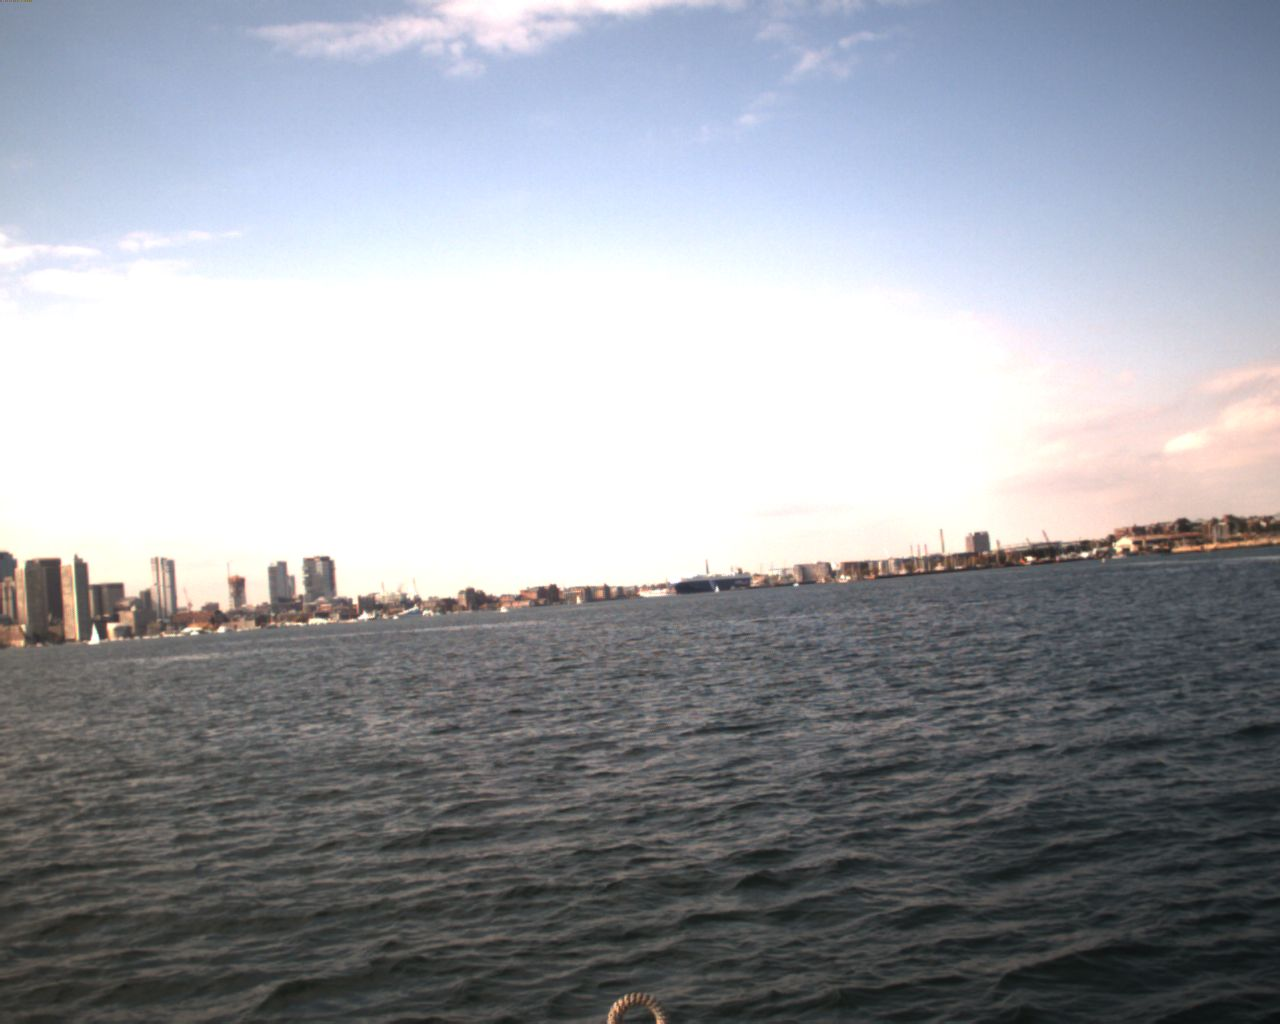

In [8]:
imd = await getBlob(client, context.userId, x9_de[0].id)
IMG_PATH='pyconvertimg.jpg'
with open(IMG_PATH, 'bw') as f:
    f.write(imd)

img = PILImage.open(IMG_PATH)
Image(filename=IMG_PATH) 

### Look at Radar Data

In [9]:
rde = filter((lambda s: 'radar' in s.label), x9_de)
for rd in rde:
    print(rd)

<BlobEntry(label=radar_mkd_full,label=radar_mkd_full,id=6751eb5f-0475-4c24-a4e7-383109e59346)>
<BlobEntry(label=radar_img,label=radar_img,id=c8b00c48-4659-4437-b1e6-743b0c4be5bb)>
<BlobEntry(label=radar_pointcloud,label=radar_pointcloud,id=82a12130-1e4e-46d0-992a-7cac5708b7ab)>


#### As PointCloud

In [16]:
rde = filter((lambda s: 'radar_pointcloud' in s.label), x9_de)
bE = next(rde)
print(bE)
    
radar_blob = await getBlob(client, context.userId, bE.id)
radar = json.loads(radar_blob)

print("Number of points: ",len(radar))
radar[0:10]

<BlobEntry(label=radar_pointcloud,label=radar_pointcloud,id=82a12130-1e4e-46d0-992a-7cac5708b7ab)>
Number of points:  643


[[-35.46592, 855.8134],
 [-119.02202, 484.61365],
 [216.1004, -631.304],
 [-158.5043, 830.0785],
 [-584.9095, -359.17392],
 [220.96115, 580.76575],
 [241.97108, 534.7688],
 [182.0528, -661.80194],
 [216.6408, 520.7562],
 [131.30196, -597.5646]]

#### Radar To Image

<BlobEntry(label=radar_img,label=radar_img,id=c8b00c48-4659-4437-b1e6-743b0c4be5bb)>


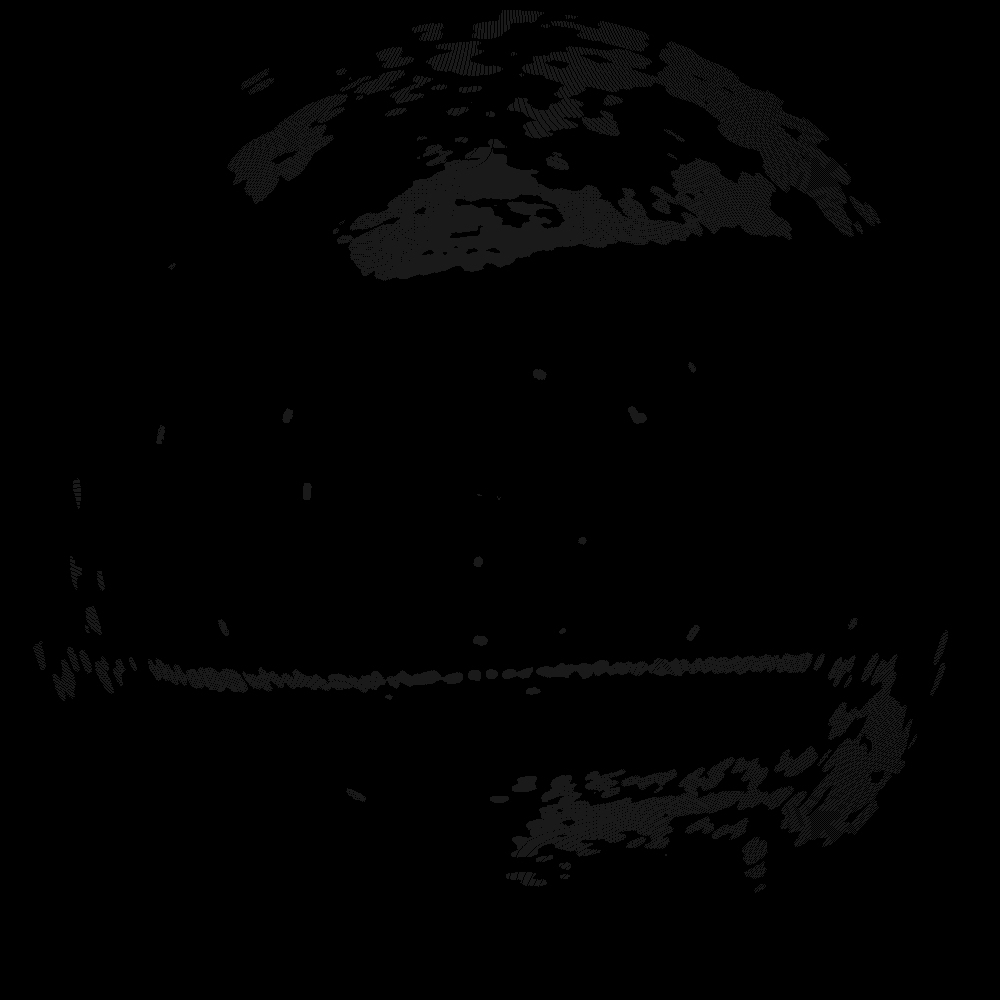

In [17]:
rde = filter((lambda s: 'radar_img' in s.label), x9_de)
bE = next(rde)
print(bE)

imd = await getBlob(client, context.userId, bE.id)
IMG_PATH='pyconvertimg.jpg'
with open(IMG_PATH, 'bw') as f:
    f.write(imd)

img = PILImage.open(IMG_PATH)
Image(filename=IMG_PATH) 

### Adding More Data

Once you have a piece of data that is pertinant for storage, you can simply add it

> Note these adds won't work since userId=`examples@navability.io` has public read-only access, but requires authentication for write access.

In [ ]:
# WRITING CHANGES WONT WORK WITHOUT AUTH for userId examples@navability.io
unique_id = await addBlob(client, "radar_pointcloud", cloudDens)
mime = "application/json/octet-stream"
addBlobEntry( 
    client, 
    context, 
    "x9", 
    unique_id, 
    "radar_pointcloud", 
    mime
)

The platform allows users to have various security/access levels as a particular application requires.

### Register a NavAbility User Login

Please contact NavAbility on [Slack](https://join.slack.com/t/caesarjl/shared_invite/zt-ucs06bwg-y2tEbddwX1vR18MASnOLsw) or info@navability.io for write, solving, and other early access features given to a specific `userId`.

## Building the Map with/without GPS

A major emphasis of this tutorial is highlighting the importance of robust navigation from all sensors and data sources, while knowing that each sensor has it's own problems and is unlikely to work perfectly 100% of the time -- e.g. GPS fails under bridges when being jammed, cameras fail when the sun or reflections are in the field of view, and radar cross section detections and shadows can vary significatnly.  By embracing non-Gaussian / multimodal data processing challenges head on, we are able to add significant value to the ease and robustness with which the necessary localization / mapping / tracking solutions that need to be developed.

[![Marine Appl Ex](http://www.navability.io/wp-content/uploads/2022/04/MarineRadarAlignFigure-1024x485-1.png)](https://www.navability.io/2022/02/04/application-example-marine-vehicle-mapping-systems-for-collision-avoidance-and-planning/)

Pull two radar sweeps and show a slice of the correlation maps from ScatterAlignPose2 -- discuss.

### Factors in the Session

In [18]:
print(await listFactors(client, context))

['x0x4f_843d', 'x0f_ca58', 'x279x284f1', 'x274x279f1', 'x269x274f1', 'x264x269f1', 'x259x264f1', 'x254x259f1', 'x249x254f1', 'x244x249f1', 'x239x244f1', 'x234x239f1', 'x229x234f1', 'x224x229f1', 'x219x224f1', 'x214x219f1', 'x209x214f1', 'x204x209f1', 'x199x204f1', 'x194x199f1', 'x189x194f1', 'x184x189f1', 'x179x184f1', 'x174x179f1', 'x169x174f1', 'x164x169f1', 'x159x164f1', 'x154x159f1', 'x149x154f1', 'x144x149f1', 'x139x144f1', 'x134x139f1', 'x129x134f1', 'x124x129f1', 'x119x124f1', 'x114x119f1', 'x109x114f1', 'x104x109f1', 'x99x104f1', 'x94x99f1', 'x89x94f1', 'x84x89f1', 'x79x84f1', 'x74x79f1', 'x69x74f1', 'x64x69f1', 'x59x64f1', 'x54x59f1', 'x49x54f1', 'x44x49f1', 'x39x44f1', 'x34x39f1', 'x29x34f1', 'x24x29f1', 'x19x24f1', 'x14x19f1', 'x9x14f1', 'x4x9f1']


We can look a bit closer at one of the radar odometry factors:

In [20]:
f_x4x9 = await getFactor(client, context, "x4x9f1")
print(f_x4x9)

<Factor(label=x4x9f1,variables=['x4', 'x9'])>


The results from the line above shows a "data" value which in this particular case is a `base64` encoded string.  That field contains the data for a `Caesar.ScatterAlignPose2` factor -- also shows by:

In [21]:
f_x4x9.fnctype

'ScatterAlignPose2'

### Aligning Radar PointCloud Maps

To learn more, the factors as well as SLAM solver code is all open-source at [`JuliaRobotics/Caesar.jl`](https://github.com/JuliaRobotics/Caesar.jl).  See the [`ScatterAlignPose2` factor code](https://github.com/JuliaRobotics/Caesar.jl/blob/b80370542e3dc958e66e2a2c022ad8e09aea2373/src/images/ScatterAlignPose2.jl#L112-L157)

## Bring your own Visualizer (BYOV)

We expect most applications already have a dedicated visualizer techonology choice, and this is good.  The localization and mapping processing here is focussed on providing robust and distributed **results which can be incorporated into existing visualization frameworks**.

### Basic awareness, App Geometric Visualization

To make this tutorial accessible, we show the Marine Case study data with the NavAbility App, which provides a basic 2D visualizer to get a basic understanding of the data:

In [ ]:
MapVizApp(context)

### NavAbility API vs SDK

The NavAbilitySDKs are wrappers on the standardized NavAbility API.  This allows simplified multilanguage support with a variety of equivalent SDKs.  The API vs SDK separation also allows separate of concerns, relating to performance code, distributed design, and language specific features/quirks.  The separation also greatly improves code legacy support and deprecation cycles.  Finally, the API vs. SDK approach allows significantly more technology-agnostic design.

To highlight how the API is used, users can try the following query which lists the sessions associated with a particular robot:

```
query {
  users(where: {id: "examples@navability.io"}) {
		robots {
      id
    }
  }
}
```

Run this query in the Playground at [`api.navability.io`](https://api.navability.io/).

## Next Steps

If you have interest in NavAbility and what our technology can do, please reach out via [Slack](https://join.slack.com/t/caesarjl/shared_invite/zt-ucs06bwg-y2tEbddwX1vR18MASnOLsw) or [info@navability.io](info@navability.io).

### NavAbility Marine Application Example

See the [NavAbility Marine Application Example](https://www.navability.io/2022/02/04/application-example-marine-vehicle-mapping-systems-for-collision-avoidance-and-planning/) for more details.

### Query spatial relationships,

- What is here there, or nearby
- What might see this target

### Find Boats in Camera Data

- Pull image data,
- Process camera image with user side needs,

### Track Boats in the Radar Data

### Combining Camera / Radar info Back into Factor Graph

- Dummy stub for uploading data back (not allowed under guest, please sign up for write access to a session)
- Pull all this data into the factor graph and ask for a new solve